In [54]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from keras.src.utils.dataset_utils import labels_to_dataset
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import l2


In [76]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
train.head()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


In [91]:
def pie(table):
    label = list(set(table.values))
    data = []
    for name_d in label:
        data.append(table.apply(lambda x: 1 if x == name_d else 0).sum())

    colors = sns.color_palette('pastel')[ 0:5 ]
    plt.pie(data, labels=label, colors=colors, autopct='%.0f%%')
    plt.show()

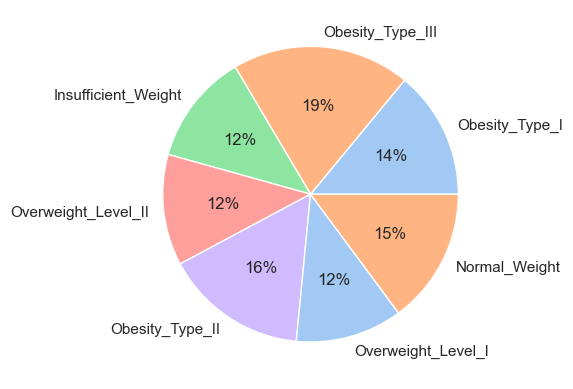

In [93]:
x = train.drop(["id","NObeyesdad"], axis=1)
y = train["NObeyesdad"]
label_encoder = LabelEncoder()
scaler = StandardScaler()
pie(train.NObeyesdad)

In [78]:
y_encoded_train = label_encoder.fit_transform(y)
columns_to_encode = ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']

for features in columns_to_encode:
    x[features]=label_encoder.fit_transform(x[features])
x.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS
0,1,24.443011,1.699998,81.669950,1,1,2.000000,2.983297,2,0,2.763573,0,0.000000,0.976473,1,3
1,0,18.000000,1.560000,57.000000,1,1,2.000000,3.000000,1,0,2.000000,0,1.000000,1.000000,2,0
2,0,18.000000,1.711460,50.165754,1,1,1.880534,1.411685,2,0,1.910378,0,0.866045,1.673584,2,3
3,0,20.952737,1.710730,131.274851,1,1,3.000000,3.000000,2,0,1.674061,0,1.467863,0.780199,1,3
4,1,31.641081,1.914186,93.798055,1,1,2.679664,1.971472,2,0,1.979848,0,1.967973,0.931721,1,3


<Axes: xlabel='Age', ylabel='Weight'>

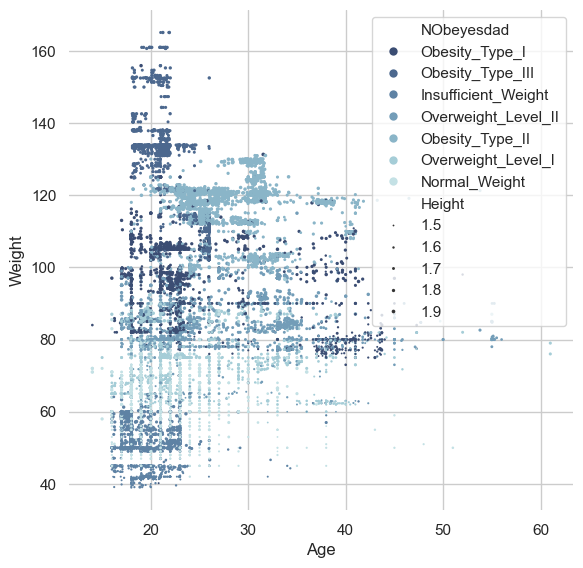

In [92]:
sns.set_theme(style="whitegrid")

data = train

f, ax = plt.subplots(figsize=(6.5, 6.5))

sns.despine(f, left=True, bottom=True)

clarity_ranking = list(set(train.NObeyesdad.values))

sns.scatterplot(x="Age", y="Weight",
                hue="NObeyesdad", size="Height",
                palette="ch:r=-.2,d=.3_r",
                hue_order=clarity_ranking,
                sizes=(1, 8), linewidth=0,
                data=data, ax=ax)

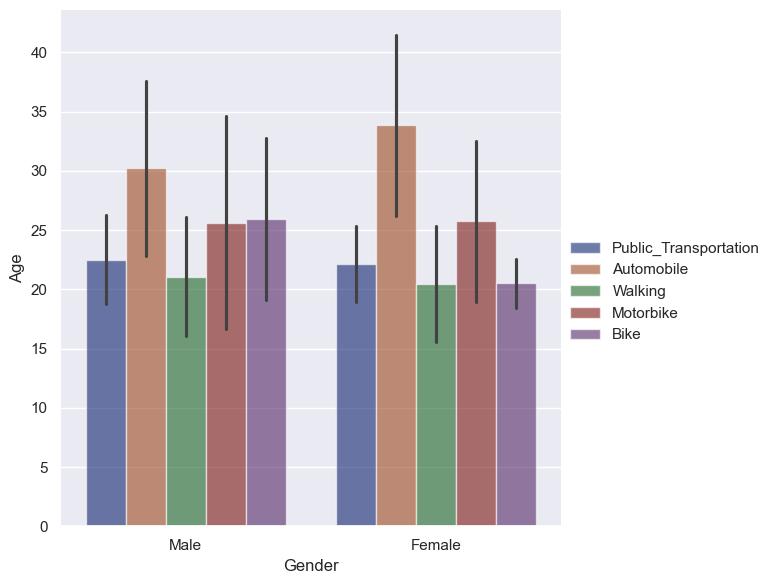

In [94]:
sns.set_theme(style="darkgrid")

g = sns.catplot(
    data=train, kind="bar",
    x="Gender", y="Age", hue="MTRANS",
    errorbar="sd", palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.legend.set_title("")

In [86]:
x_encoded_normalized_train=scaler.fit_transform(x)
x_normalized_df = pd.DataFrame(x_encoded_normalized_train, columns=x.columns)

In [88]:
def get_model():
    model = keras.Sequential([
    layers.Input(shape=(x_encoded_normalized_train.shape[1],)),
    layers.Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    layers.Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    keras.layers.Dropout(.2),
    layers.Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    layers.Dense(7, activation='softmax')
])
    return model

In [89]:
LR = 0.0001
BATCH_SIZE = 25
VAL_SPLIT = 0.2
PATIENCE = 20
EPOCHS = 500
model = get_model()

In [90]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=PATIENCE,
    restore_best_weights=True
)

In [71]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=LR), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

history = model.fit(x_encoded_normalized_train, y_encoded_train, 
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE, 
                    validation_split=VAL_SPLIT, 
                    callbacks=[early_stopping])

train_loss, train_accuracy = model.evaluate(x_encoded_normalized_train, y_encoded_train)


Epoch 1/500
665/665 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.4143 - loss: 1.8142 - val_accuracy: 0.7177 - val_loss: 1.0258
Epoch 2/500
665/665 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7111 - loss: 1.0078 - val_accuracy: 0.7917 - val_loss: 0.8035
Epoch 3/500
665/665 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7802 - loss: 0.8329 - val_accuracy: 0.8215 - val_loss: 0.7142
Epoch 4/500
665/665 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8143 - loss: 0.7230 - val_accuracy: 0.8437 - val_loss: 0.6630
Epoch 5/500
665/665 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8301 - loss: 0.6877 - val_accuracy: 0.8492 - val_loss: 0.6317
Epoch 6/500
665/665 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8506 - loss: 0.6427 - val_accuracy: 0.8589 - val_loss: 0.6102
Epoch 7/500
665/665 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8488 - loss: 0.6264 - val_accuracy: 0.8591 - val_loss: 0.5972
Epoch 8/500
665/665 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8527 - loss: 0.6126 - val_accu

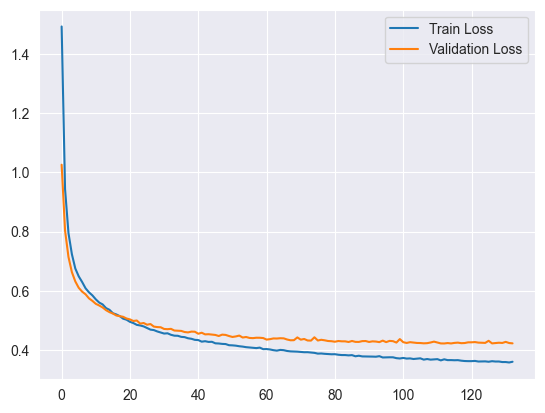

In [72]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()
